In [1]:
import os

from torchvision.utils import save_image
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torchvision import transforms
from PIL import Image
from torch import nn
import numpy as np
import torch

from misc.utils import AdaIN, coral
from net import model

/root/anaconda3/envs/torch_1.x/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
args = edict({})
args.size      = 256
args.crop      = True
args.style     = 'assets/styles'
args.alpha     = 1.0
args.device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.content   = 'assets/contents'
args.encoder   = 'assets/vgg_normalised.pth'
args.decoder   = 'assets/results/decoder_160000.pth'
args.save_ext  = '.jpg'
args.save_path = 'assets/output'
args.preserve_color        = True
args.do_interpolation      = False
args.interpolation_weights = ''

os.makedirs(args.save_path, exist_ok = True)

In [3]:
def test_transform(size, crop):

    transform_list = []
    if size != 0: transform_list.append(transforms.Resize(size))

    if crop: transform_list.append(transforms.CenterCrop(size))

    transform_list.append(transforms.ToTensor())

    return transforms.Compose(transform_list)


def style_transfer(encoder, decoder, content, style, 
                   alpha = 1.0, interpolation_weights = None):

    content_f = encoder(content)
    style_f   =   encoder(style)

    if interpolation_weights:

        _, C, H, W = content_f.size()
        feat       = torch.FloatTensor(1, C, H, W).zero_().to(args.device)
        base_feat  = AdaIN(content_f, style_f)

        for idx, weight in enumerate(interpolation_weights):
            feat = feat + weight * base_feat[idx : idx + 1]
        content_f = content_f[0:1]
        
    else: 
        feat = AdaIN(content_f,style_f)

    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)
                   

In [4]:
contents_paths = sorted(list_images(args.content))
style_paths    = sorted(list_images(args.style))

In [5]:
decoder = model.Decoder()
encoder = model.Encoder()

decoder.eval()
encoder.eval()

decoder.load_state_dict(torch.load(args.decoder))
encoder.load_state_dict(torch.load(args.encoder), strict = False)
encoder = nn.Sequential(*list(list(encoder.children())[0].children())[:31])

decoder.to(args.device)
encoder.to(args.device)

print('모델 로딩 완.')

모델 로딩 완.


In [6]:
content_tf    = test_transform(args.size, args.crop)
style_tf      = test_transform(args.size, args.crop)

content_image = Image.open(contents_paths[0]).convert('RGB')
style_image   =    Image.open(style_paths[0]).convert('RGB')
    
content_image = content_tf(content_image)
style_image   =     style_tf(style_image)

if args.preserve_color:
    style_image = coral(style_image, content_image)

content_image = content_image.to(args.device).unsqueeze(0)
style_image   =   style_image.to(args.device).unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

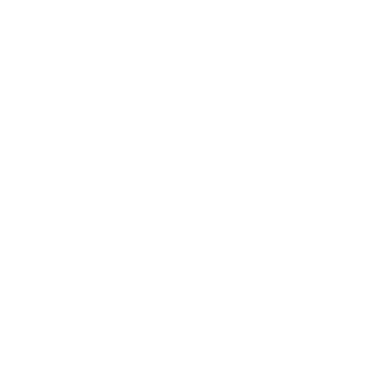

In [7]:
with torch.no_grad():
    output = style_transfer(encoder, decoder, content_image, style_image, args.alpha)

output = output.cpu().numpy()
output = np.transpose(output.squeeze(), (1, 2, 0))

plt.imshow(output * 255)
plt.axis(False)